# Exoplanet Convolutional Neural Network (CNN) Classifier
Here we will use a CNN to classify if a star observed by Kepler contains a exoplanet 

In [1]:
import tensorflow.keras.models
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.layers import Embedding
# from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

First lets load the data and preprocess it.

In [39]:
def load_data(path):
    data = pd.read_csv(path)

    # Convert columns to something more useful.
    for i, column in enumerate(data.columns):
        if 'FLUX' in column:
            data.columns.values[i] = int(column.split('.')[1])
    # Also change labels so 0 is non-exoplanet and 1 is exoplanet
    data.LABEL -= 1
    return data

def normalize_data(df):
    """
    Normalize a Kepler light curve DatFrame with a mean subtraction and 
    """
    # Calculate the mean of each light curve and subtract it
    df_norm = df.copy()
    mean = df_norm.iloc[:, 1:].mean(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].subtract(mean, axis=0)
    # Calculate the standard deviation of each light curve and divide.
    std = df_norm.iloc[:, 1:].std(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].divide(std, axis=0)
    return df_norm


train_data = load_data('./data/exoTrain.csv')
train_data = normalize_data(train_data)

test_data = load_data('./data/exoTest.csv')
test_data = normalize_data(test_data)

Now reshape the arrays to input into the CNN.

In [18]:
train_data_array, train_data_labels = train_data.iloc[:, 1:].values, train_data.iloc[:, 0].values
train_data_array = train_data_array.reshape(*train_data_array.shape, 1)
train_data_labels = train_data_labels.reshape(train_data_labels.shape[0], 1)

test_data_array, test_data_labels = test_data.iloc[:, 1:].values, test_data.iloc[:, 0].values
test_data_array = test_data_array.reshape(*test_data_array.shape, 1)
test_data_labels = test_data_labels.reshape(test_data_labels.shape[0], 1)

print(train_data_array.shape, train_data_labels.shape)
print(test_data_array.shape, test_data_labels.shape)

(5087, 3197, 1) (5087, 1)
(570, 3197, 1) (570, 1)


To ballance the data set we create a batch function to return equal number of exoplanet and non-exoplanet light curves. There will be duplicate light curves.

In [37]:
def light_curve_batch(train_df, batch_size=32):
    """
    Returns equal number of random exoplanets and non-exoplanet detections.
    """
    exo_df = train_df[train_df.LABEL == 1].sample(n=batch_size//2, 
        random_state=123, replace=True)
    nonexo_df = train_df[train_df.LABEL == 0].sample(n=batch_size//2,
        random_state=123, replace=True)
    df = pd.concat([exo_df, nonexo_df])
    df = df.sample(frac=1).reset_index(drop=True)
    light_curves = df.iloc[:, 1:]
    labels = df.iloc[:, 0]
    return [light_curves.values], labels.values

In [32]:
model1 = tensorflow.keras.models.Sequential()
model1.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=train_data_array.shape[1:]))
model1.add(MaxPooling1D(strides=4))
model1.add(Flatten())
# model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [33]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 3187, 8)           96        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 797, 8)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6376)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                408128    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 408,289
Trainable params: 408,289
Non-trainable params: 0
_________________________________________________________________


In [34]:
model1.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

hist = model1.fit(train_data_array, train_data_labels, 
                validation_data=(test_data_array, test_data_labels), 
                verbose=2, epochs=5)

Train on 5087 samples, validate on 570 samples
Epoch 1/5
5087/5087 - 5s - loss: 0.1658 - accuracy: 0.9662 - val_loss: 0.0576 - val_accuracy: 0.9912
Epoch 2/5
5087/5087 - 5s - loss: 0.0486 - accuracy: 0.9925 - val_loss: 0.0512 - val_accuracy: 0.9912
Epoch 3/5
5087/5087 - 5s - loss: 0.0446 - accuracy: 0.9927 - val_loss: 0.0501 - val_accuracy: 0.9912
Epoch 4/5
5087/5087 - 5s - loss: 0.0428 - accuracy: 0.9927 - val_loss: 0.0493 - val_accuracy: 0.9912
Epoch 5/5
5087/5087 - 5s - loss: 0.0412 - accuracy: 0.9927 - val_loss: 0.0487 - val_accuracy: 0.9912


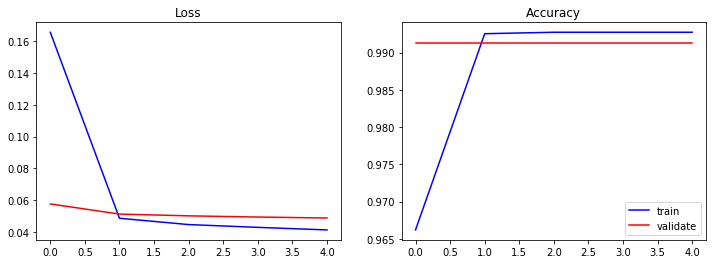

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(hist.history['loss'], color='b')
ax[0].plot(hist.history['val_loss'], color='r')
ax[1].plot(hist.history['accuracy'], color='b', label='train')
ax[1].plot(hist.history['val_accuracy'], color='r', label='validate')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[1].legend()

In [37]:
model1.evaluate(test_data_array, test_data_labels, verbose=2)

570/570 - 0s - loss: 0.0487 - accuracy: 0.9912


[0.048735514087112325, 0.99122804]